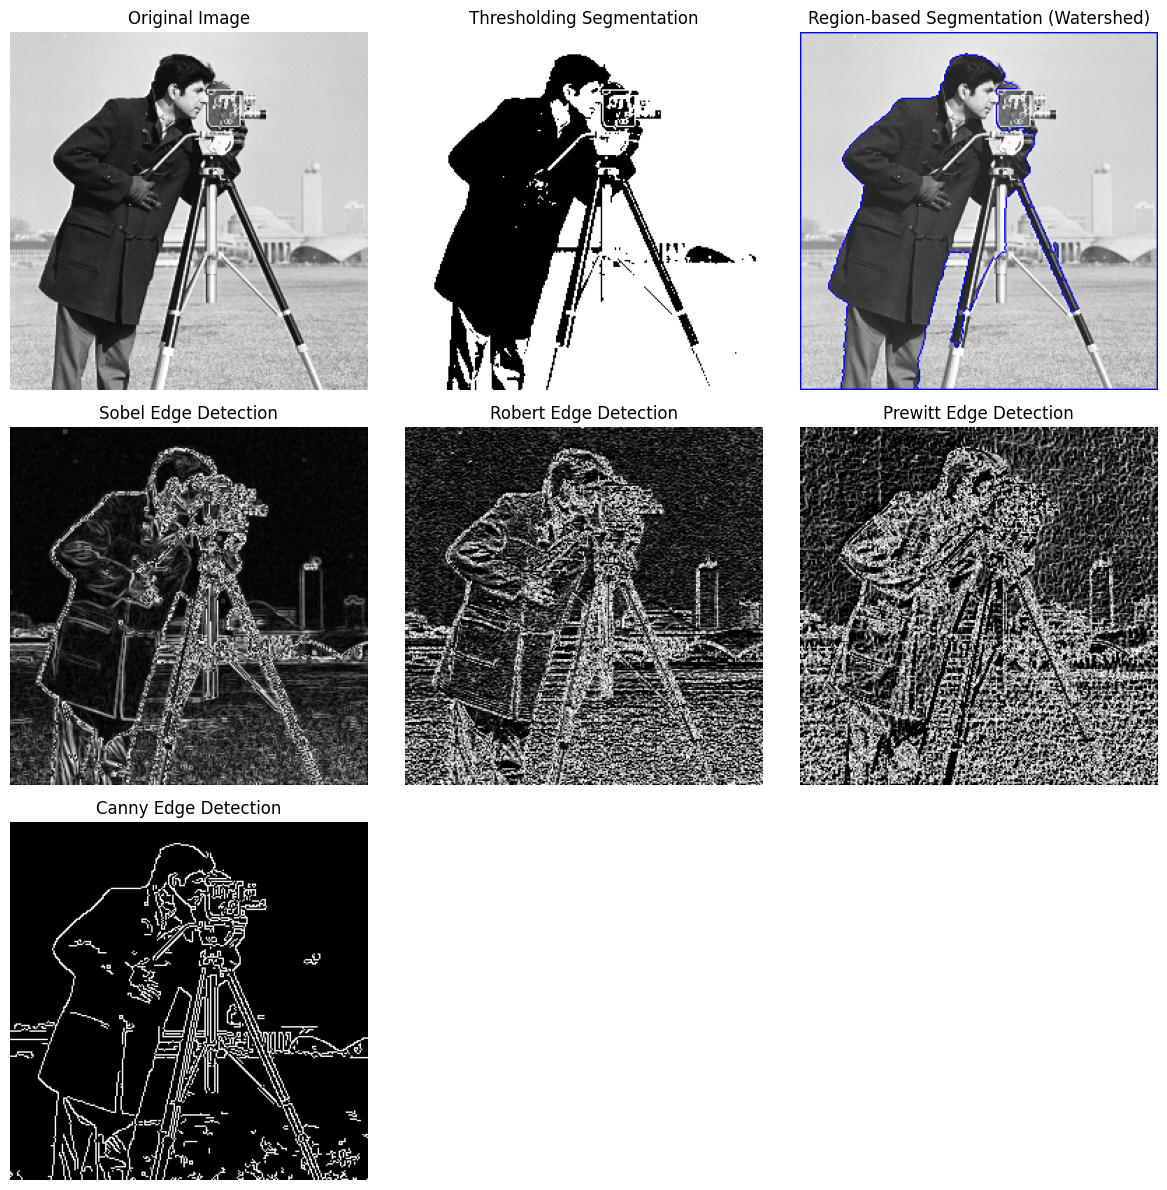

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

image_path = '/content/cameraman-testimage.png'
if not os.path.exists(image_path):
    raise ValueError(f"File not found at {image_path}. Please check the file path or upload the image.")

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    raise ValueError("Unable to load image. Check the path.")

_, thresholded_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

ret, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)

if binary_image is None or binary_image.size == 0:
    raise ValueError("Thresholding failed, binary image is empty.")

kernel = np.ones((3, 3), np.uint8)
binary_image = cv2.dilate(binary_image, kernel, iterations=3)

dist_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

sure_bg = cv2.dilate(binary_image, kernel, iterations=3)
unknown = cv2.subtract(sure_bg, sure_fg)

_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

image_colored = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.watershed(image_colored, markers)
image_colored[markers == -1] = [0, 0, 255]

sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
sobel_edges = cv2.magnitude(sobel_x, sobel_y)
sobel_edges = np.uint8(np.absolute(sobel_edges))

robert_kernel_x = np.array([[1, 0], [0, -1]], dtype=np.float32)
robert_kernel_y = np.array([[0, 1], [-1, 0]], dtype=np.float32)
robert_x = cv2.filter2D(image, -1, robert_kernel_x)
robert_y = cv2.filter2D(image, -1, robert_kernel_y)
robert_edges = np.sqrt(np.square(robert_x) + np.square(robert_y))
robert_edges = np.uint8(np.absolute(robert_edges))

prewitt_kernel_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], dtype=np.float32)
prewitt_kernel_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], dtype=np.float32)
prewitt_x = cv2.filter2D(image, -1, prewitt_kernel_x)
prewitt_y = cv2.filter2D(image, -1, prewitt_kernel_y)
prewitt_edges = np.sqrt(np.square(prewitt_x) + np.square(prewitt_y))
prewitt_edges = np.uint8(np.absolute(prewitt_edges))

edges_canny = cv2.Canny(image, 100, 200)

plt.figure(figsize=(12, 12))

plt.subplot(3, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(3, 3, 2)
plt.imshow(thresholded_image, cmap='gray')
plt.title("Thresholding Segmentation")
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(image_colored)
plt.title("Region-based Segmentation (Watershed)")
plt.axis('off')

plt.subplot(3, 3, 4)
plt.imshow(sobel_edges, cmap='gray')
plt.title("Sobel Edge Detection")
plt.axis('off')

plt.subplot(3, 3, 5)
plt.imshow(robert_edges, cmap='gray')
plt.title("Robert Edge Detection")
plt.axis('off')

plt.subplot(3, 3, 6)
plt.imshow(prewitt_edges, cmap='gray')
plt.title("Prewitt Edge Detection")
plt.axis('off')

plt.subplot(3, 3, 7)
plt.imshow(edges_canny, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')

plt.tight_layout()
plt.show()
